# INFO 2950: Phase II
#### Group Members: Anusha Bishayee, Katheryn Ding

---
### __Research Question:__  

#### How do ESG score and stock performance (price) align across different industries? What associations can we find between company industry, stock performance, and ESG ratings?
#### note: ESG score refers to a quantiative metric measuring a company's environmental, social, and governance performance; 'environmental' pertains to aspects like waste management and energy emissions, 'social' pertains to aspects like customer satisfaction and DEI in the workplace, and 'governance' pertains to aspects like operating efficiencies and risk management. ESG scores are typically examined by independent investors, business analysts, and even competitior companies to assess risk or opportunities associated with a specific company's practices.



---
### __Data Collection and Cleaning:__

In [72]:
import contextlib
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

our original dataset with ESG information for different large/mid-cap companies came in a csv format, which we downloaded from Kaggle. this had about 722 rows, each corresponding to a unique publicly traded company. further description of the columns here can be found in the 'Dataset Description' portion of this notebook.

we first dropped all rows that had null values, which eliminated 27 companies. we then filtered this dataset for just USD currency, excluding companies that are traded in CNY or any other currency. this allows us to have greater familiarity with the industries and companies we analyze - this process eliminated 15 more of our rows, and left us with 680 companies.

In [73]:
esg = pd.read_csv("esg_data.csv")
print(f"original data shape: {esg.shape}")

esg = esg.dropna()
print(f"non-null data shape: {esg.shape}")

esg = esg[esg["currency"] == "USD"]
print(f"refined data shape: {esg.shape}")

original data shape: (722, 21)
non-null data shape: (695, 21)
refined data shape: (680, 21)


then, we converted the 'last_processing_date' column in our dataset to DateTime format - a lot of rows had a differing date formats as well, so we had to convert them all to m/d/y. after that, we sorted the dataset by ascending and descending 'last_processing_date' to see the range of processing dates in the data. 

In [74]:
esg["last_processing_date"] = pd.to_datetime(esg["last_processing_date"], format = "mixed")
esg["last_processing_date"] = esg["last_processing_date"].dt.strftime('%m-%d-%Y')

esg = esg.sort_values(by = "last_processing_date", ascending = False)
print(f"latest dates:\n{esg["last_processing_date"].head(2)}")

esg = esg.sort_values(by = "last_processing_date", ascending = True)
print(f"\nearliest dates:\n{esg["last_processing_date"].head(2)}")

latest dates:
720    11-15-2022
716    11-15-2022
Name: last_processing_date, dtype: object

earliest dates:
658    02-08-2022
36     04-16-2022
Name: last_processing_date, dtype: object


after this, we realized we have two 'Energy' values for the 'industry' column - one is 'Energy ' and one is 'Energy'. we renamed all the 'Energy ' values, and also re-formatted some other industry column values.

In [75]:
esg['industry'] = esg['industry'].replace('Energy ', 'Energy')
esg['industry'] = esg['industry'].replace('Hotels, Restaurants & Leisure', 'Hotels, Restaurants, & Leisure')
esg['industry'] = esg['industry'].replace('Hotels Restaurants and Leisure', 'Hotels, Restaurants, & Leisure')
esg['industry'] = esg['industry'].replace('Consumer products', 'Consumer Products')
esg['industry'] = esg['industry'].replace('Logistics and Transportation', 'Logistics & Transportation')
esg['industry'] = esg['industry'].replace('Life Sciences Tools and Services', 'Life Sciences Tools & Services')
esg['industry'] = esg['industry'].replace('Commercial Services and Supplies', 'Commercial Services & Supplies')
esg['industry'] = esg['industry'].replace('Road and Rail', 'Road & Rail')
esg['industry'] = esg['industry'].replace('Metals and Mining', 'Metals & Mining')
esg['industry'] = esg['industry'].replace('Aerospace and Defense', 'Aerospace & Defense')
esg['industry'] = esg['industry'].replace('Textiles Apparel and Luxury Goods', 'Textiles, Apparel, & Luxury Goods')
esg['industry'] = esg['industry'].replace('Trading Companies and Distributors', 'Trading Companies & Distributors')

print(esg['industry'].unique())

['Leisure Products' 'Semiconductors' 'Health Care' 'Chemicals'
 'Telecommunication' 'Consumer Products' 'Airlines' 'Insurance'
 'Communications' 'Building' 'Technology' 'Logistics & Transportation'
 'Biotechnology' 'Banking' 'Pharmaceuticals' 'Financial Services'
 'Life Sciences Tools & Services' 'Electrical Equipment' 'Real Estate'
 'Machinery' 'Retail' 'Food Products' 'Industrial Conglomerates'
 'Hotels, Restaurants, & Leisure' 'Utilities' 'Beverages' 'Tobacco'
 'Media' 'Auto Components' 'Energy' 'Commercial Services & Supplies'
 'Packaging' 'Road & Rail' 'Metals & Mining'
 'Textiles, Apparel, & Luxury Goods' 'Trading Companies & Distributors'
 'Aerospace & Defense' 'Automobiles' 'Distributors'
 'Professional Services' 'Construction' 'Marine'
 'Diversified Consumer Services']


now, we wanted to add our finance data from the yfinance library onto to our esg dataset. we used the ticker column to match up companies from the yfinance library and our esg dataset, and we set our dates of the finance data to range from 2/1/21 to 12/31/22, as all of the 'last processing date' values for the esg data range from 2/8/22 to 11/15/22. in specific, we calculated a stock percentage change over this period for each company, a volatility index, a 50-day moving average, and a cumulative return metric.

In [76]:
# prevents some annoying yfinance outputs from printing, gpt was used to assist here
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

tickers = esg["ticker"].tolist()
stock_data = []

for ticker in tickers:
    try:
        # suppresses all of the outputs when grabbing data from yfinance
        with suppress_output():  
            stock = yf.download(ticker, start = "2021-02-01", end = "2022-12-31", progress = False)
        
        if not stock.empty:
            # get closing price for 01/01/2021 and 12/31/2022
            close_2021_02_01 = stock.loc["2021-02-01"]["Close"] if "2021-02-01" in stock.index else None
            close_2022_12_31 = stock.loc["2022-12-30"]["Close"] if "2022-12-30" in stock.index else None

            # calculating percentage change
            percentage_change = ((stock["Close"].iloc[-1] - stock["Close"].iloc[0]) / stock["Close"].iloc[0]) * 100
            
            # calculating volatility (sd of daily returns)
            daily_returns = stock["Close"].pct_change()
            volatility = daily_returns.std()
            
            # calculating 50-day moving average
            stock["50_day_SMA"] = stock["Close"].rolling(window=50).mean()
            sma_50_day = stock["50_day_SMA"].iloc[-1]
            
            # calculating cumulative return
            cumulative_return = (stock["Close"].iloc[-1] / stock["Close"].iloc[0]) - 1
            
            stock_data.append({
                'ticker': ticker, 
                'start_close': close_2021_02_01,
                'end_close': close_2022_12_31,
                'percentage_change': percentage_change,
                'volatility': volatility,
                '50_day_SMA': sma_50_day,
                'cumulative_return': cumulative_return
            })
            
    # also helps to suppress annoying outputs
    except (yf.YFTzMissingError, yf.YFPricesMissingError):
        pass 

now, we needed to convert the stock data we extracted from yfinance to a dataframe, so that we can merge it with our original esg dataframe.

In [77]:
stock_df = pd.DataFrame(stock_data)
merged_df = esg.merge(stock_df, on = 'ticker', how = 'left')
print(f"current data shape: {merged_df.shape}")
print(f"\n{merged_df.head()}")

current data shape: (680, 27)

  ticker                           name currency  \
0   poww                       Ammo Inc      USD   
1   acls       Axcelis Technologies Inc      USD   
2   achc  Acadia Healthcare Company Inc      USD   
3     cf     CF Industries Holdings Inc      USD   
4      t                       AT&T Inc      USD   

                        exchange           industry  \
0     NASDAQ NMS - GLOBAL MARKET   Leisure Products   
1     NASDAQ NMS - GLOBAL MARKET     Semiconductors   
2     NASDAQ NMS - GLOBAL MARKET        Health Care   
3  NEW YORK STOCK EXCHANGE, INC.          Chemicals   
4  NEW YORK STOCK EXCHANGE, INC.  Telecommunication   

                                                logo  \
0  https://static.finnhub.io/logo/8decc6ca0564a89...   
1  https://static.finnhub.io/logo/88b5f730-80df-1...   
2  https://static.finnhub.io/logo/4b6b2e5a4cfce5b...   
3  https://static.finnhub.io/logo/9b57a636-80eb-1...   
4  https://static.finnhub.io/logo/7d20269e-80

after that, we needed to drop any rows where the finance data join has left null values. this eliminates 80 more of our rows, leaving us with 600 companies.

In [78]:
merged_df = merged_df.dropna()
print(f"non-null finance data shape: {merged_df.shape}\n")

merged_df = merged_df.sort_values(by = "name", ascending = True)
print(merged_df.head)

non-null finance data shape: (594, 27)

<bound method NDFrame.head of     ticker                             name currency  \
71     mmm                            3M Co      USD   
142    aos                   A O Smith Corp      USD   
661   abvc               ABVC Biopharma Inc      USD   
17    acad       ACADIA Pharmaceuticals Inc      USD   
41    aciw                ACI Worldwide Inc      USD   
..     ...                              ...      ...   
500    zts                       Zoetis Inc      USD   
571    zuo                        Zuora Inc      USD   
643    zws  Zurn Elkay Water Solutions Corp      USD   
647   zyme                    Zymeworks Inc      USD   
189   ebay                         eBay Inc      USD   

                          exchange                  industry  \
71   NEW YORK STOCK EXCHANGE, INC.  Industrial Conglomerates   
142  NEW YORK STOCK EXCHANGE, INC.                  Building   
661     NASDAQ NMS - GLOBAL MARKET             Biotechnology   
1

In [79]:
merged_df = merged_df.drop(['exchange', 'logo', 'weburl','cik'],axis=1)
merged_df.columns

Index(['ticker', 'name', 'currency', 'industry', 'environment_grade',
       'environment_level', 'social_grade', 'social_level', 'governance_grade',
       'governance_level', 'environment_score', 'social_score',
       'governance_score', 'total_score', 'last_processing_date',
       'total_grade', 'total_level', 'start_close', 'end_close',
       'percentage_change', 'volatility', '50_day_SMA', 'cumulative_return'],
      dtype='object')

this is still a lot of data, but will be helpful for getting industry-level and other general overviews of the data. merged_df will be our main dataframe.
   
we also want to create a sample of these 600 companies so that we are able to look at trends and associations at the individual company-level as well.   
   
since we want to take random sample stratum on industries and total ESG score:
1. We first list all industries with descending total_score, then separate the industries based on total_score into three groups: high/medium/low ESG based on their rank.
2. Then, we use  .sample() to randomly choose two industries from each group, which generates 6 industries.
3. For each of the randomly chosen industries, we randomly pick 5 companies from each industry, which generates 30 companies in the sample_companies.
   
By applying this sampling process, we ensure our sample by industries is representative of all levels of ESG scores. gpt was used here for assistance with the sampling. sample_companies will be our 2nd dataframe.

In [80]:
warnings.filterwarnings("ignore", category = DeprecationWarning)
np.random.seed(123)

avg_esg_by_industry = merged_df.groupby('industry')['total_score'].mean().reset_index()
avg_esg_by_industry.columns = ['Industry', 'Average Total ESG Score']
avg_esg_by_industry = avg_esg_by_industry.sort_values(by = 'Average Total ESG Score', ascending = False)

third = len(avg_esg_by_industry) // 3
high_group = avg_esg_by_industry.iloc[:third]
medium_group = avg_esg_by_industry.iloc[third: 2 * third]
low_group = avg_esg_by_industry.iloc[2 * third:]

random_high_industries = high_group.sample(2)['Industry'].tolist()
random_medium_industries = medium_group.sample(2)['Industry'].tolist()
random_low_industries = low_group.sample(2)['Industry'].tolist()

print(f"randomly selected high ESG industries: {random_high_industries}")
print(f"randomly selected medium ESG industries: {random_medium_industries}")
print(f"randomly selected low ESG industries: {random_low_industries}")

high_industry_companies = merged_df[merged_df['industry'].isin(random_high_industries)]
medium_industry_companies = merged_df[merged_df['industry'].isin(random_medium_industries)]
low_industry_companies = merged_df[merged_df['industry'].isin(random_low_industries)]

high_industry_companies_sampled = high_industry_companies.groupby('industry', group_keys = False).apply(lambda x: x.sample(min(len(x), 5))).reset_index(drop = True)
high_industry_companies_sampled['ESG score level'] = 'High'
medium_industry_companies_sampled = medium_industry_companies.groupby('industry', group_keys = False).apply(lambda x: x.sample(min(len(x), 5))).reset_index(drop = True)
medium_industry_companies_sampled['ESG score level'] = 'Medium'
low_industry_companies_sampled = low_industry_companies.groupby('industry', group_keys = False).apply(lambda x: x.sample(min(len(x), 5))).reset_index(drop = True)
low_industry_companies_sampled['ESG score level'] = 'Low'

sample_companies = pd.concat([high_industry_companies_sampled, medium_industry_companies_sampled, low_industry_companies_sampled])
print(sample_companies)

randomly selected high ESG industries: ['Building', 'Road & Rail']
randomly selected medium ESG industries: ['Professional Services', 'Real Estate']
randomly selected low ESG industries: ['Marine', 'Biotechnology']
  ticker                                  name currency  \
0     tt                Trane Technologies PLC      USD   
1    mas                            Masco Corp      USD   
2    zws       Zurn Elkay Water Solutions Corp      USD   
3    aos                        A O Smith Corp      USD   
4   aaon                              Aaon Inc      USD   
5    xpo                     XPO Logistics Inc      USD   
6    unp                    Union Pacific Corp      USD   
7    csx                              CSX Corp      USD   
8    nsc                 Norfolk Southern Corp      USD   
9   odfl         Old Dominion Freight Line Inc      USD   
0   ldos                   Leidos Holdings Inc      USD   
1    efx                           Equifax Inc      USD   
2   upwk          

finally, we also extracted some general S&P 500 data from yfinance, ranging from the dates of 2/1/21 and 12/31/22 for the same reason. we are pulling this data so that we can compare stock performance of the individual companies to the overall S&P 500 in the same time range. sp500 will be our 3rd dataset.

In [81]:
sp500data = yf.download('^GSPC', start = '2021-02-01', end = '2022-12-31', progress = False)
sp500 = pd.DataFrame({
    'Date': sp500data.index,
    'Start Price': sp500data['Open'],
    'End Price': sp500data['Close'],
    'Rate of Change': ((sp500data['Close'] - sp500data['Open']) / sp500data['Open']) * 100 })

sp500.set_index('Date', inplace = True)
print(sp500)

            Start Price    End Price  Rate of Change
Date                                                
2021-02-01  3731.169922  3773.860107        1.144150
2021-02-02  3791.840088  3826.310059        0.909057
2021-02-03  3840.270020  3830.169922       -0.263005
2021-02-04  3836.659912  3871.739990        0.914339
2021-02-05  3878.300049  3886.830078        0.219942
...                 ...          ...             ...
2022-12-23  3815.110107  3844.820068        0.778745
2022-12-27  3843.340088  3829.250000       -0.366610
2022-12-28  3829.560059  3783.219971       -1.210063
2022-12-29  3805.449951  3849.280029        1.151771
2022-12-30  3829.060059  3839.500000        0.272650

[484 rows x 3 columns]


---
### __Data Description__
1) Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box).

- We have 3 main datasets: 1 main dataset (merged_df), 1 "sample" dataset that selects 30 rows from this main dataset (sample_companies), and 1 additional dataset (sp500). Our raw data for the first 2 datasets can be found on Kaggle, here: https://github.com/anushabishayee/info2950_finalproject/blob/main/raw%20data/esg%20kaggle%20csv%20link and the actual csv is here: https://github.com/anushabishayee/info2950_finalproject/blob/main/esg_data.csv.
- Even more specifically, the Kaggle author states that they pulled the data for their csv from multiple APIs, like ESG Enterprise, a publicly-available API. They grabbed financial and company data from Finnhub. 3 of these links can be found here: https://github.com/anushabishayee/info2950_finalproject/blob/main/raw%20data/esg%20kaggle%20source%20data%20links.
- The finance data that the 3rd dataset is comprised of, and the finance data that is joined to the 1st and 2nd datasets is found in the yfinance library in Python (Yahoo Finance data, https://github.com/anushabishayee/info2950_finalproject/blob/main/raw%20data/yfinance%20links).

***

2) If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?

- Individuals are not involved in the data directly, as each observation corresponds to an entire company.

***

3) What preprocessing was done, and how did the data come to be in the form that you are using?

- Our preprocessing of these datasets is detailed above. Generally, we imported the yfinance library, downloaded the Kaggle csv with the company ESG data, cleaned the dataset for NaNs and unneeded values, and reformatted some date values for ease of manipulation. Then, we joined the ESG data to the yfinance stock data, matching on company ticker (we created 4 new stock metric columns), and dropped NaNs for the creation of merged_df. For the 2nd dataset (sample_companies), we stratified and randomly selected 30 specific companies from this main dataset (specific methodology is outlined above in the 'Data Collection and Cleaning' section. For the 3rd dataset, we extracted the data straight from the yfinance library, and calculated a rate of change variable for the stock change as well for sp500.
- For the Kaggle csv, the author notes that they used company stock ticker as a unique identifier, then pulled and collated data from various APIs. in specific, they utilized ESG Enterprise (https://www.esgenterprise.com/), a publicly-available API, and pulled their ratings methodology from https://app.esgenterprise.com/uploads/ESG-Enterprise-Risk-Ratings-MethodologyV3.pdf. They grabbed financial and company data from Finnhub (https://finnhub.io/).

***

4) What processes might have influenced what data was observed and recorded and what was not?

- For the ESG data, the Kaggle author of the csv specifically mentioned that only mid/large-cap companies are included, so this influences the specific companies that are recorded in the initial data - smaller companies (that also might have an ESG score) will not be 'observed' here. The author pulled data from ESG Enterprise and Finnhub, so any companies that do not have data available there will not be observed in the dataset. We also dropped any company that had a NaN or blank column value for the ESG columns, and dropped any company that didn't have stock data available in Yahoo Finance (or had NaNs for any specific finance column).

***

5) Who funded the creation of the dataset?

- We created these 3 analysis-ready datasets from two data sources: a 'Public Company ESG Ratings Dataset' Kaggle dataset from user Alistair King (https://www.kaggle.com/alistairking), a New York-based Kaggle Datasets Grandmaster, as well as the yfinance Python library, created by Ran Aroussi (https://aroussi.com/) as a way around the 2017 Yahoo Finance API deprecation. It is unclear if these datasets were 'funded', but their organization and accumulation were spearheaded by the two aforementioned people, respectively.

***

6) Why was this dataset created?
- We formulated our main analysis-ready dataset (merged_df) to examine associations between some of the largest USD-utilizing companies' ESG scores and their stock performances (as well as industry-specific analyses). Then, we formulated our sample dataset (sample_companies) so that we could take a look at some company-level analyses of the general data and research question (620 companies are kinda hard to visualize simultaneously). Finally, we formulated the sp500 dataset so that we could contrast company stock performance from the specified range of 2/1/21 - 12/31/22 to the overall performance of the S&P 500. (the rationale for the range of 2/1/21 - 12/31/22 is mentioned above, it's due to the fact that most companies have a 'last processing date' of February 2022 - Novermber 2022 for their ESG score.)
- The original ESG csv was created and uploaded by Kaggle user Alistair King, perhaps for personal enrichment or curiosity (they do have a Kaggle Datasets Grandmaster rank, so perhaps they just enjoy creating and uploading datasets). The original yfinance Python library was created by Ran Aroussi to have a simple way to download historical market data from Yahoo Finance, due to the Yahoo Finance API deprecation.

***

7) What are the observations (rows) and attributes (columns)?
- For the S&P 500 dataset (sp500), the rows each correspond to a specific date where the S&P 500 was measured, within the range from 2/1/21 - 12/31/22. The columns for this dataset are Start Price, End Price, and Rate of Change (aka the starting price of the S&P 500 when the US market opened on a specific day, the ending price of the S&P 500 when the US market closed on the same specific day, and the percentage change that this stock exhibited between the start and close times of that specific day (100 * (end price - start price) / start price)).

- For both the merged_df and sample_companies dataset, each row corresponds to an unique, mid- to large-cap company that is publicly-traded and utilizes USD. merged_df, our main dataset, has 620 companies, while sample_companies has 30 companies for now. merged_df and sample_companies have the same columns, they are:
+ ticker - a unique combo of letters and numbers that represent a particular stock
+ name - the official name of the company
+ currency - the currency the company is traded in (this was filtered to only be USD)
+ exchange - what market the company is exchanged on
+ industry - the type of output the company produces
+ logo - a link to the company logo, potentially for joining with other datasets (MIGHT BE DROPPED LATER)
+ weburl - a link to the company website, potentially for joining with other datasets or scraping for text sentiment analysis (MIGHT BE DROPPED LATER)
+ environment_grade - a letter score given to the company that measures how well it complies to environmental standards, ranging from AAA being the best to CCC being the worst
+ environment_level - a categorical classification of a company's overall environmental performance (low, medium, high)
+ social_grade - a letter score given to the company that measures how well it complies to social standards, ranging from AAA being the best to CCC being the worst
+ social_level - a categorical classification of a company's overall social performance (low, medium, high)
+ governance_grade - a letter score given to the company that measures how well it complies to governance standards, ranging from AAA being the best to CCC being the worst
+ governance_level - a categorical classification of a company's overall governance performance (low, medium, high)
+ environment_score - a numerical measure of how well a company performs on environment-related factors, ranging from 0-1000
+ social_score - a numerical measure of how well a company performs on social-related factors, ranging from 0-1000
+ governance_score - a numerical measure of how well a company performs on governance-related factors, ranging from 0-1000
+ total_score - a numerical measure of how well a company performs on environment, social, and governance-related factors, ranging from 0-1500]
+ cik - central index key, a unique identifier assigned by the SEC to any company that files documents with the SEC (MIGHT BE DROPPED LATER)
the following columns are ones that we created, using the yfinance data:
+ percent_change - the percent change in the company stock price from close time on 2/1/21 to close time on 12/31/22 (100 * (end price - start price) / start price))
+ start_close - the closing price of the company stock on 2/1/21
+ end_close - the closing price of the company stock on 12/31/22
+ volatility - standard deviation of daily returns of the company stock, aka the percentage change in the stock price from day to day (indicator of how much stock price fluctuates in a given period, higher volatility is riskier, lower volatility has more stability). specifically, daily return is calculated by closing price on day x+1 - closing price on day x divided by closing price on day x, so all daily returns in the time period 2/1/21-12/31/22 are calculated for the specific company stock, and then the standard deviation is taken to get the volatility
+ 50_day_SMA - 50 day simple moving average, or the sum of closing price of a company stock for the last 50 days before 12/31/22, divided by 50 (if current stock price is above the 50-day SMA, the company is in uptrend, and vice versa)
+ cumulative_return - cumulative return of the company stock over the entire period ((close price on 12/31/22 / close price on 2/1/21) - 1), positive values represent returns, and negative values represent losses

---
### __Data Limitations__

1. ESG is typically evaluated annually, which might mean the scores in our dataset don't reflect the most accurate performance of the company, which directly impacts the analyses and conclusions we might draw from our EDA. in other words, when considering the short-term impact of the company's ESG and other policies, it's likely that policy change affect stocks immediately, but these changes might not also be reflected in the company's ESG rating. Bascially, since ESG scores lag behind the stock fluctuations due to immediate events (mergers, acqusitions, freak events like the CrowdStrike failure), any significant events that occur during 2/1/21-12/31/22 may result in stock price changes that do not perfectly correlate to ESG metrics. This could skew our correlation or regression model analysis, so we want to be careful to not falsely attributing any stock changes to ESG scores (in case of possible confounding variables). As a caveat, we should also be careful not to infer any causal relations when correlation exists.

2. ESG is a constant value that is gathered from different days for each company in 2022, though stock prices for these companies change over time every day. We cannot perform any time-series analyses with ESG due to this fact, which limits what we can do for our final phases and EDA.
   
3. Due to the nature of the Kaggle csv and yfinance data, our data is restricted to the variable types of stock data, industry type, company name, and ESG score - which actually does help us narrow down the scope of our research question, but limits the breadth of the analyses we can perform as well.
   
4. Some specific data from the yfinance library is missing - we had to drop all companies that didn't have the specified data we wanted in our specified time range. We also had to drop all companies from the original ESG csv that had missing or blank data. Overall, this means that our analyses will not be perfectly representative of all companies that use USD and have an ESG rating (can't perfectly generalize to the population). Additionally, we filtered our original ESG dataframe to be just companies traded in USD, so we can't do any inter-country comparison (although this also helps us narrow the scope of our project). Since we are also only using companies that are existent and large/mid-cap within 2/1/21 - 12/31/22, any company that stopped their operations in this time frame will be excluded. In other words, our findings might disproportionally overestimate the relationship between ESG scores and stock performance (companies that went bankrupt or have poor ESG / financial outcomes are not represented, which might skew interpretation of ESG positively).
   
5. For our sample dataset (companies_sample), the current 30 companies were chosen with a stratified sample. As a reminder, essentially, we looked at all of the different industries, and ranked them by total ESG score. then, we divided up the industries into 3 groups: high ESG score, medium ESG score, and low ESG score. Then, from each group, we chose 2 industries from a random sample. After this, we then randomly selected 5 companies from each industry, giving us a dataset of 30 companies. This sample is not fully representative of all USD-using companies with ESG ratings (this actually ties into one of our questions for reviewers). After getting feedback, we may also consider complete random sampling (no stratification) to expand the representativeness of our sample dataset, but since we are exploring potential connections between ESG ratings and company stock performance, we may need to sample not only by industry but also by ESG rating levels to ensure a more balanced and comprehensive analysis of the different ESG performance tiers (for our sample dataset). Furthermore, though our sample size is sufficient to assume normality in distribution, it is still rather small compared to merged_df's number of companies included, so our findings might reflect trends only in specific industries or companies rather than the average and general market trends.
   
6. We currently plan on comparing the rate of change of the sample stocks (in companies_sample) to the S&P 500's rate of change. We also plan on taking a look at volatility, cumulative returns, and the 50 day simple moving average, but other measures of stock performance might provide more valuable insights (but we will proceed with these 4 for now). Additionally, due to the last processing date of the ESG scores for the companies, we also restricted our stock data to be from 2/1/21 - 12/31/22, which poses a limitation on the amount of analyses we can garner as we cannot extrapolate our conclusions to beyond this time frame. 

---
### __Exploratory Data Analysis:__

### part one - exploring average environmental, social, governance, and total ESG scores by industry

##### total esg score by industry

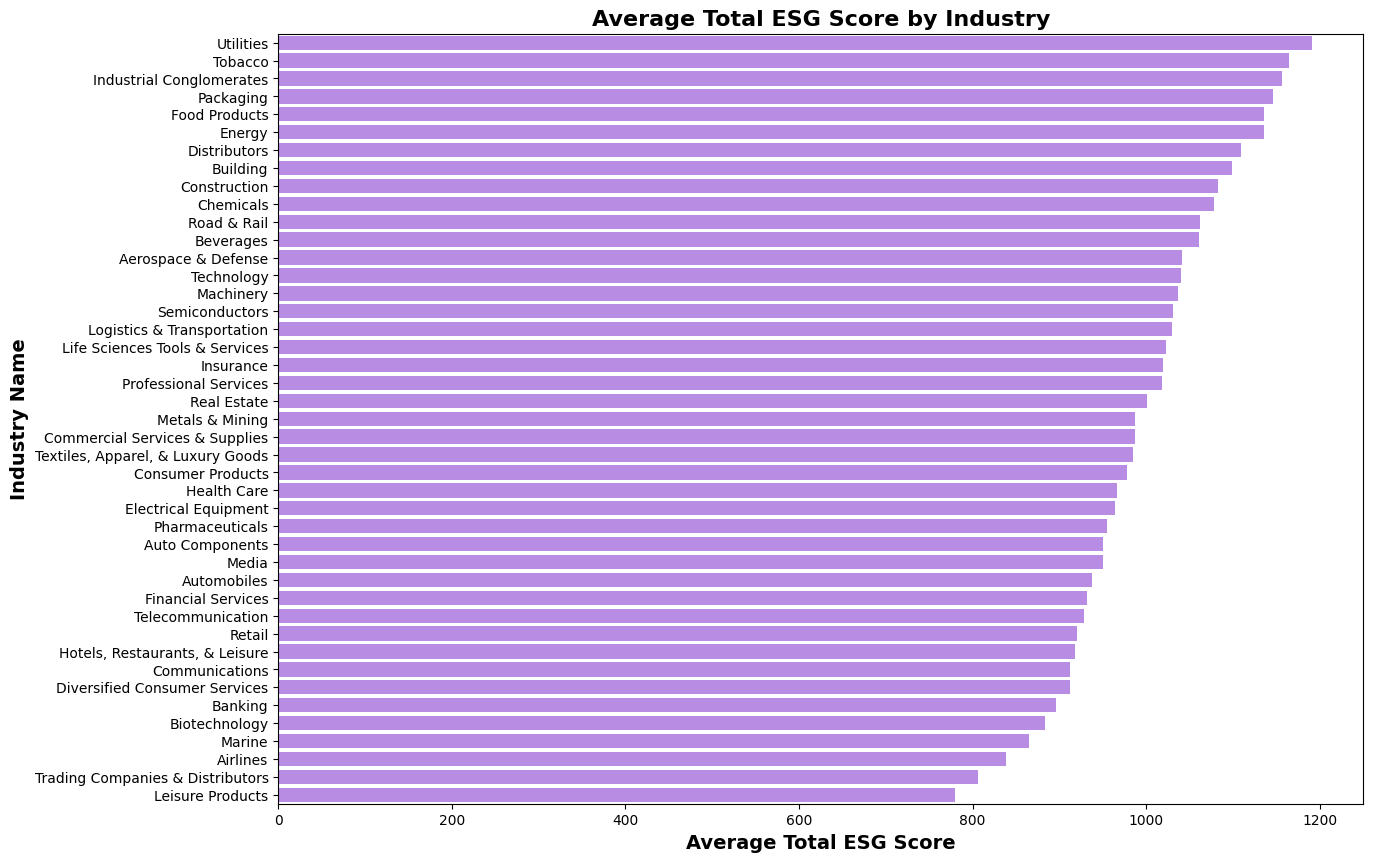

In [82]:
plt.figure(figsize = (14, 10))
sns.barplot(x = 'Average Total ESG Score', y = 'Industry', data = avg_esg_by_industry, color = "#b97df3")
plt.title('Average Total ESG Score by Industry', horizontalalignment = 'center', fontsize = 16, fontweight = 'bold', )
plt.xlabel('Average Total ESG Score', fontsize = 14, fontweight = 'bold', horizontalalignment = 'center')
plt.ylabel('Industry Name', fontsize = 14, fontweight = 'bold', horizontalalignment = 'center')
plt.show()

interestingly (and somewhat predictably) - the industries with the lowest ESG scores are Leisure Products, Airlines, Marine, Biotechnology, and Banking. the industries with the highest ESG scores are Utilities, Tobacco, Industrial Conglomerates, Packaging, and Industrial Conglomerates. This is relevant to our research question as we wanted to explore associations between industry and ESG ranking, so it will also be interesting to see if there are differences in this ranking when dividing ESG into its component parts.

##### environmental score by industry

In [83]:
# enviro ranking
avg_enviro_by_industry = merged_df.groupby('industry')['environment_score'].mean().reset_index()
avg_enviro_by_industry.columns = ['Industry', 'Average Environmental Score']

avg_enviro_by_industry = avg_enviro_by_industry.sort_values(by = 'Average Environmental Score', ascending = False)
print("best average Environment scores")
print(avg_enviro_by_industry.head(6))

avg_enviro_by_industry = avg_enviro_by_industry.sort_values(by = 'Average Environmental Score', ascending = True)
print("\nworst average Environment scores")
print(avg_enviro_by_industry.head(6))

best average Environment scores
                    Industry  Average Environmental Score
42                 Utilities                   550.966667
21  Industrial Conglomerates                   534.666667
30                 Packaging                   530.000000
13              Distributors                   525.000000
16                    Energy                   522.555556
18             Food Products                   517.076923

worst average Environment scores
                            Industry  Average Environmental Score
41  Trading Companies & Distributors                   242.500000
23                  Leisure Products                   252.333333
27                            Marine                   305.333333
6                      Biotechnology                   318.324324
1                           Airlines                   326.714286
4                            Banking                   341.000000


##### social score by industry

In [84]:
# social ranking
avg_social_by_industry = merged_df.groupby('industry')['social_score'].mean().reset_index()
avg_social_by_industry.columns = ['Industry', 'Average Social Score']

avg_social_by_industry = avg_social_by_industry.sort_values(by = 'Average Social Score', ascending = False)
print("best average social scores")
print(avg_social_by_industry.head(6))

avg_social_by_industry = avg_social_by_industry.sort_values(by = 'Average Social Score', ascending = True)
print("\nworst average social scores")
print(avg_social_by_industry.head(6))

best average social scores
                            Industry  Average Social Score
42                         Utilities            357.400000
41  Trading Companies & Distributors            343.500000
35                       Road & Rail            329.400000
40                           Tobacco            327.000000
30                         Packaging            322.666667
21          Industrial Conglomerates            318.000000

worst average social scores
            Industry  Average Social Score
3        Automobiles            236.333333
23  Leisure Products            259.333333
1           Airlines            265.714286
10    Communications            271.500000
6      Biotechnology            271.837838
2    Auto Components            272.500000


##### governance score by industry

In [85]:
# gov ranking
avg_gov_by_industry = merged_df.groupby('industry')['governance_score'].mean().reset_index()
avg_gov_by_industry.columns = ['Industry', 'Average Governance Score']

avg_gov_by_industry = avg_gov_by_industry.sort_values(by = 'Average Governance Score', ascending = False)
print("best average governance scores")
print(avg_gov_by_industry.head(6))

avg_gov_by_industry = avg_gov_by_industry.sort_values(by = 'Average Governance Score', ascending = True)
print("\nworst average governance scores")
print(avg_gov_by_industry.head(6))

best average governance scores
                    Industry  Average Governance Score
40                   Tobacco                328.000000
13              Distributors                307.666667
21  Industrial Conglomerates                304.333333
18             Food Products                303.076923
16                    Energy                299.611111
32     Professional Services                298.600000

worst average governance scores
                            Industry  Average Governance Score
41  Trading Companies & Distributors                220.000000
1                           Airlines                246.285714
3                        Automobiles                249.333333
14     Diversified Consumer Services                250.000000
20    Hotels, Restaurants, & Leisure                260.913043
9     Commercial Services & Supplies                262.200000


##### environmental, social, and governance scores by industry

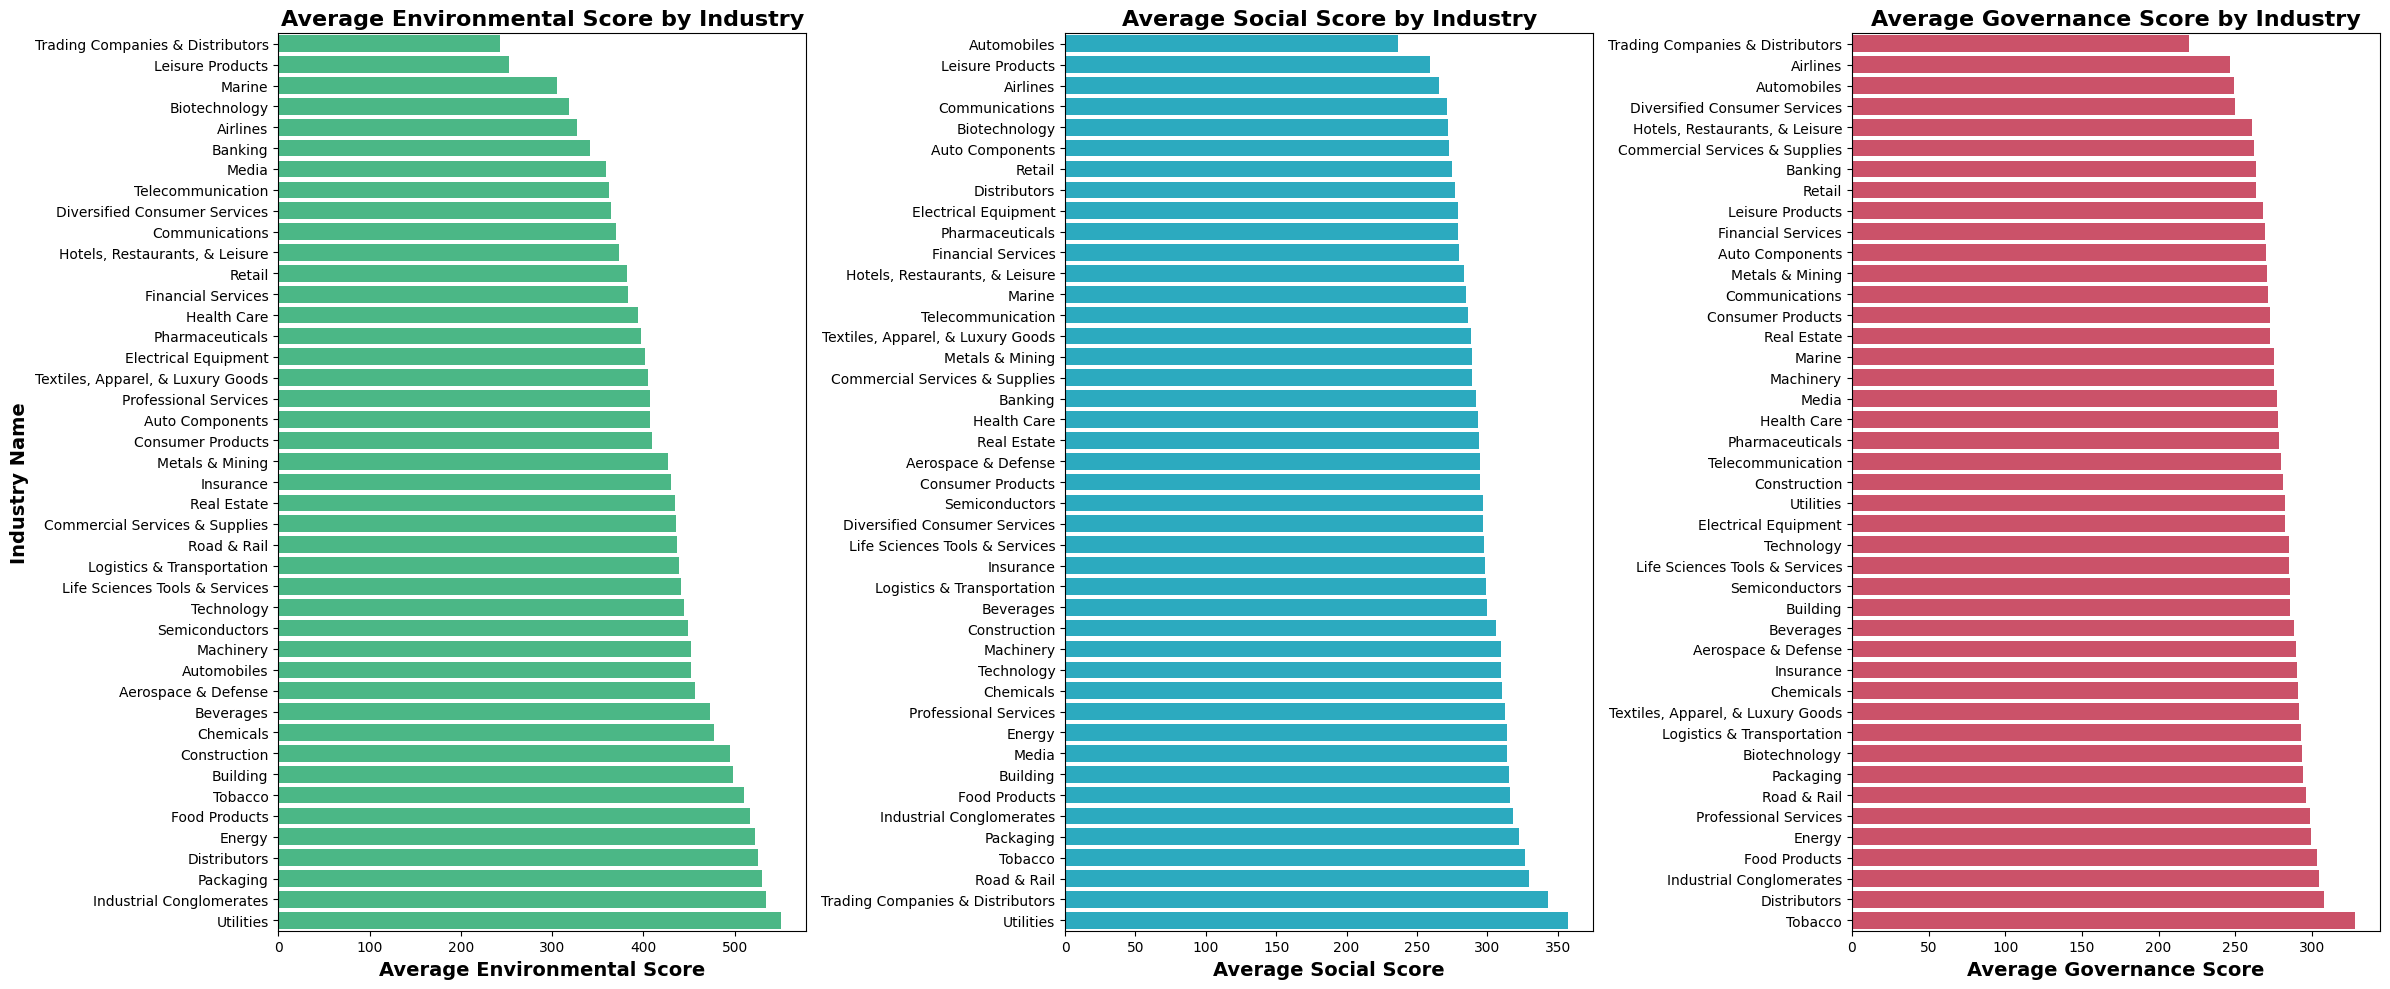

In [86]:
fig, axes = plt.subplots(1, 3, figsize = (24, 10)) 

# Plot 1: Average Environmental Score by Industry
sns.barplot(x = 'Average Environmental Score', y = 'Industry', data = avg_enviro_by_industry, color = "#39c988", ax = axes[0])
axes[0].set_title('Average Environmental Score by Industry', horizontalalignment = 'center', fontsize = 16, fontweight = 'bold')
axes[0].set_xlabel('Average Environmental Score', fontsize = 14, fontweight = 'bold', horizontalalignment = 'center')
axes[0].set_ylabel('Industry Name', fontsize = 14, fontweight = 'bold', horizontalalignment = 'center')

# Plot 2: Average Social Score by Industry
sns.barplot(x ='Average Social Score', y = 'Industry', data = avg_social_by_industry, color = "#13bcd8", ax = axes[1])
axes[1].set_title('Average Social Score by Industry', horizontalalignment = 'center', fontsize = 16, fontweight = 'bold')
axes[1].set_xlabel('Average Social Score', fontsize = 14, fontweight = 'bold', horizontalalignment = 'center')
axes[1].set_ylabel('') 

# Plot 3: Average Governance Score by Industry
sns.barplot(x ='Average Governance Score', y = 'Industry', data = avg_gov_by_industry, color = "#df3e5d", ax = axes[2])
axes[2].set_title('Average Governance Score by Industry', horizontalalignment = 'center', fontsize = 16, fontweight = 'bold')
axes[2].set_xlabel('Average Governance Score', fontsize = 14, fontweight = 'bold', horizontalalignment = 'center')
axes[2].set_ylabel('') 

plt.tight_layout()
plt.show()

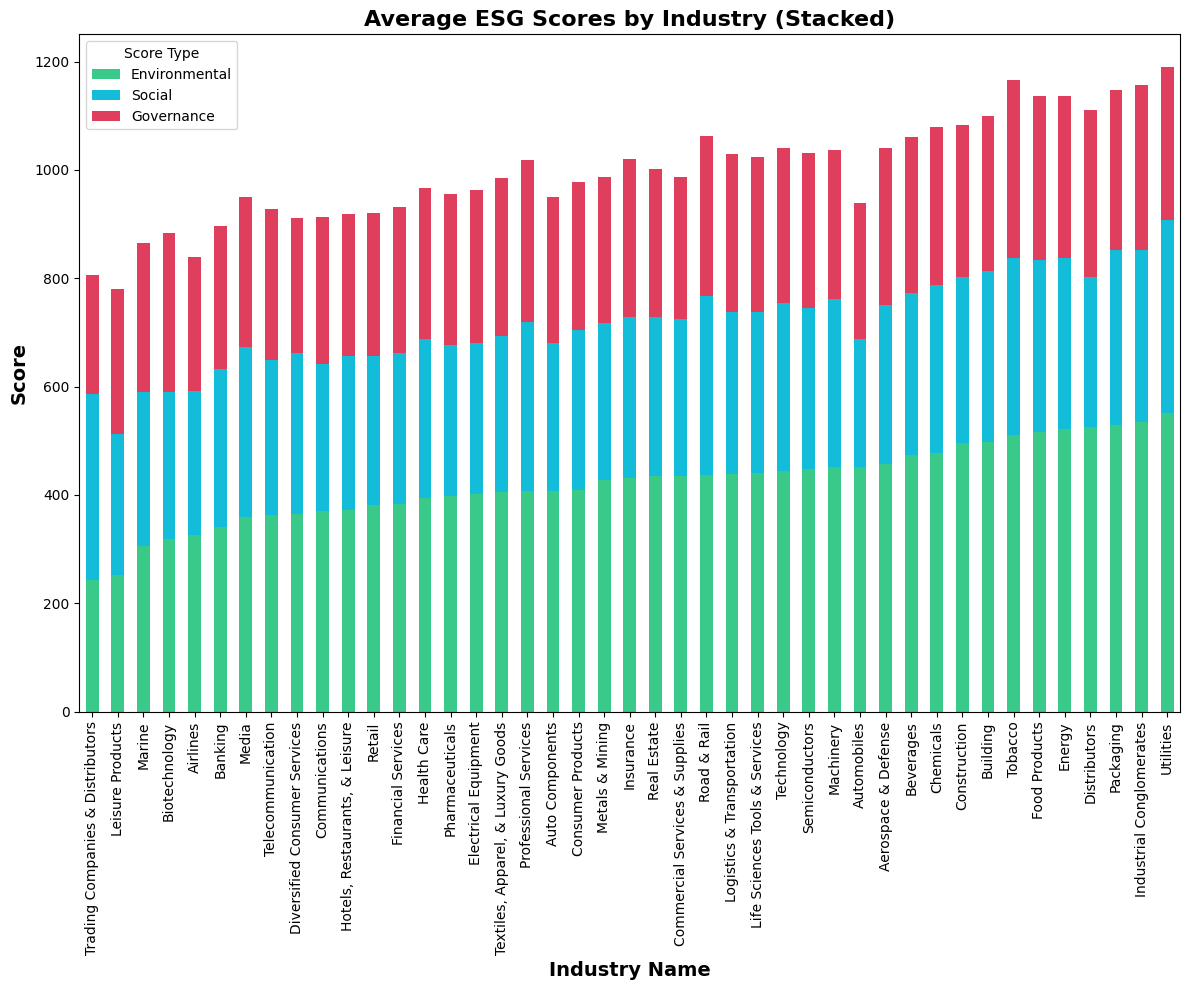

In [ ]:
avg_enviro_by_industry_ = avg_enviro_by_industry.rename(columns = {'Average Environmental Score': 'Environmental'})
avg_social_by_industry_ = avg_social_by_industry.rename(columns = {'Average Social Score': 'Social'})
avg_gov_by_industry_ = avg_gov_by_industry.rename(columns = {'Average Governance Score': 'Governance'})
stacked_data = avg_enviro_by_industry_.merge(avg_social_by_industry_, on='Industry').merge(avg_gov_by_industry_, on='Industry')

fig, ax = plt.subplots()
stacked_data.set_index('Industry').plot(kind = 'bar', stacked = True, ax = ax, color = ['#39c988', '#13bcd8', '#df3e5d'])
ax.set_title('Average ESG Scores by Industry', fontsize = 16, fontweight = 'bold', horizontalalignment = 'center')
ax.set_xlabel('Industry Name', fontsize = 14, fontweight = 'bold')
ax.set_ylabel('Score', fontsize = 14, fontweight = 'bold')
plt.xticks(rotation = 90)  
plt.legend(title = 'Score Type')
plt.tight_layout()
plt.show()

the industries with the lowest Environmental scores are also Leisure Products, Marine, Biotechnology, Trading Companies & Distributors, and Airlines. the industries with the highest Environmental scores are also Utilities, Industrial Conglomerates, Packaging, Distributors, and Energy. 

the industries with the lowest Social scores are Automobiles, Leisure Products, Airlines, Biotechnology, and Communications. the industries with the highest Social scores are also Utilities, Trading Companies & Distributors, Road & Rail, Tobacco, and Packaging. 

the industries with the lowest Governance scores are Airlines, Trading Companies & Distributors, Automobiles, Diversified Consumer Services, and Hotels, Restaurants, & Leisure. the industries with the highest Governance scores are also Tobacco, Distributors, Industrial Conglomerates, Food Products, and Tobacco.

overall, it looks like Airlines is an industry that performs especially bad in all 3 metrics, and Distributors does pretty well in all 3 metrics. 

---
### part two - distribution of ESG scores, with respect to grade and level


#### initial: esg scores across all companies

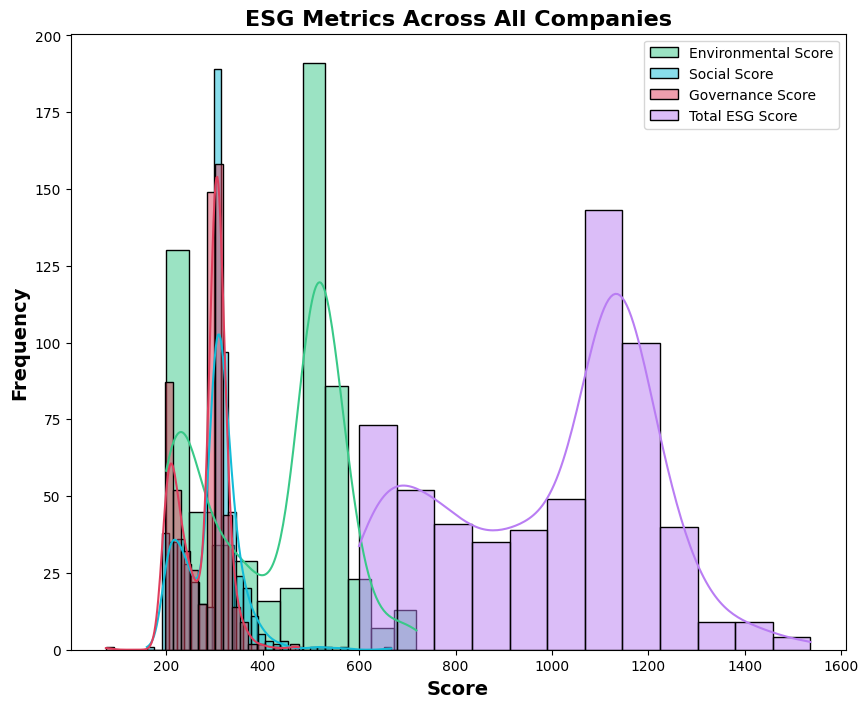

In [ ]:
plt.figure(figsize = (10, 8))
sns.histplot(merged_df['environment_score'], kde = True, color = '#39c988', label = 'Environmental Score')
sns.histplot(merged_df['social_score'], kde = True, color = '#13bcd8', label = 'Social Score')
sns.histplot(merged_df['governance_score'], kde = True, color = '#df3e5d', label = 'Governance Score')
#sns.histplot(merged_df['total_score'], kde = True, color = '#b97df3', label = 'Total ESG Score')

plt.title('ESG Metrics Across All Companies', fontsize = 16, fontweight = 'bold', horizontalalignment = 'center')
plt.xlabel('Score', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold')
plt.legend()
plt.show()

This plot highlights the distribution of Environmental, Social, Governance (E/S/G) scores and the total ESG score across companies. A clear bimodal pattern in the total ESG score (purple) suggests two main groups of companies — one with lower scores around 600-800 and another with higher scores around 1000-1200. In terms of the indivisual ESG socres, the Environmental score (green) shows the widest spread, indicating greater variability than Social and Governance scores (blue and red), which are more concentrated. This plot provides information about ESG scores distribution, giving us some general understanding about ESG score in our datasets.      

#### distribution of ESG wrt Level and Industry

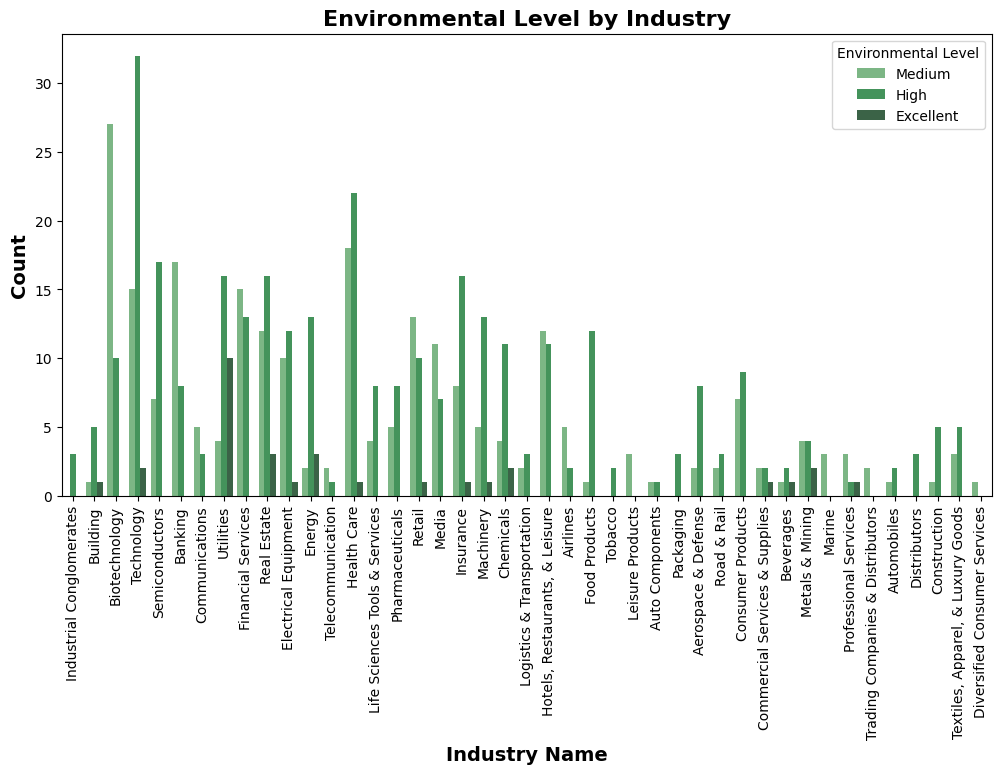

In [ ]:
# Count plot for Environmental Level
plt.figure(figsize = (12, 6))
sns.countplot(data = merged_df, x = 'industry', hue = 'environment_level', palette = 'Greens_d', hue_order = ['Medium', 'High', 'Excellent'])
plt.title('Environmental Level by Industry', horizontalalignment = 'center', fontweight = 'bold', fontsize = 16)
plt.xticks(rotation = 90)
plt.xlabel('Industry Name', horizontalalignment = 'center', fontweight = 'bold', fontsize = 14)
plt.ylabel('Count', horizontalalignment = 'center', fontweight = 'bold', fontsize = 14)
plt.legend(title = 'Environmental Level')
plt.show()

The plot shows distribution of Environmental levels for each industry. In terms of coloration, the darker the color is, the higher Environmental level is indicated. As indicated by the plot, the distribution of companies in each Environmental level are relatively wide spreaded, in which most of the companies has "Medium" or "High" Environmental levels, but the population with "High" environmental level are not extremely low. Overall, this plot provides an overview about the Environmental level across industries.     

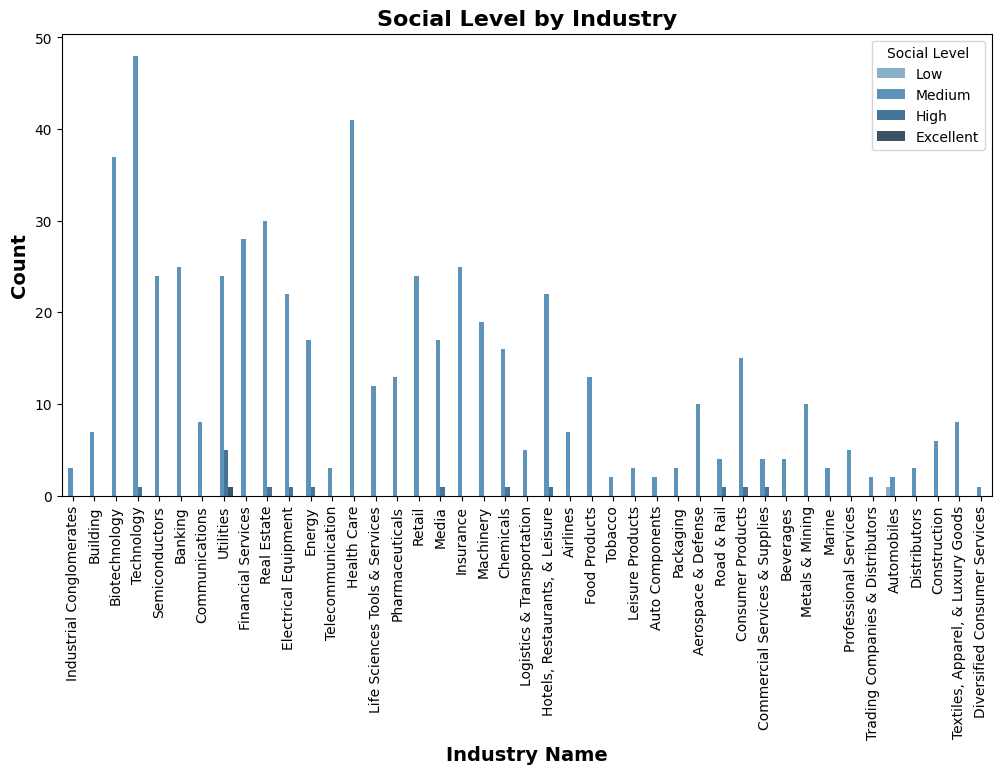

In [ ]:
# Count plot for Social Level
plt.figure(figsize = (12, 6))
sns.countplot(data = merged_df, x = 'industry', hue = 'social_level', palette = 'Blues_d', hue_order = ['Low','Medium', 'High', 'Excellent'])
plt.title('Social Level by Industry', fontsize = 16, fontweight = 'bold', horizontalalignment = 'center')
plt.xticks(rotation = 90)
plt.xlabel('Industry Name', horizontalalignment = 'center', fontweight = 'bold', fontsize = 14)
plt.ylabel('Count', horizontalalignment = 'center', fontweight = 'bold', fontsize = 14)
plt.legend(title = 'Social Level')
plt.show()

The plot shows distribution of Social levels for each industry. In terms of coloration, the darker the color is, the higher Social level is indicated. Based on the graph, most of the companies in the population has "Medium" or "High" social levels and just a few companies (less then 10) has "Excellent" or "Low" Social levels. 

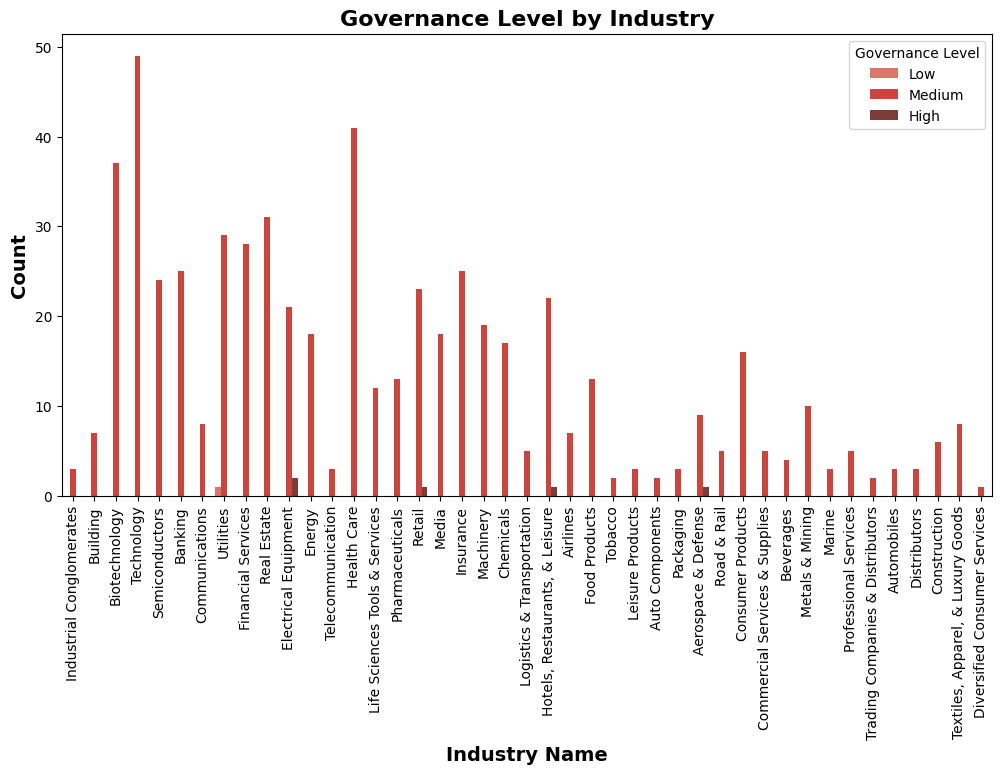

In [ ]:
# Count plot for Governance Level
plt.figure(figsize = (12, 6))
sns.countplot(data = merged_df, x = 'industry', hue = 'governance_level', palette = 'Reds_d', hue_order = ['Low','Medium', 'High'])
plt.title('Governance Level by Industry', fontsize = 16, fontweight = 'bold', horizontalalignment = 'center')
plt.xticks(rotation = 90)
plt.xlabel('Industry Name', fontsize = 14, fontweight = 'bold')
plt.ylabel('Count', fontsize = 14, fontweight = 'bold')
plt.legend(title = 'Governance Level')
plt.show()

The plot shows distribution of Governance levels for each industry. In terms of coloration, the darker the color is, the higher Governance level is indicated. Basd on the graph, most of the companies in the population has "Medium" Governance levels and just 5 has "High" and only 1 "Low" Governance levels, which indicates more concentrated Governance Level comparing to Social or Environmental Levels.     

#### distribution of ESG wrt Grade and Industry

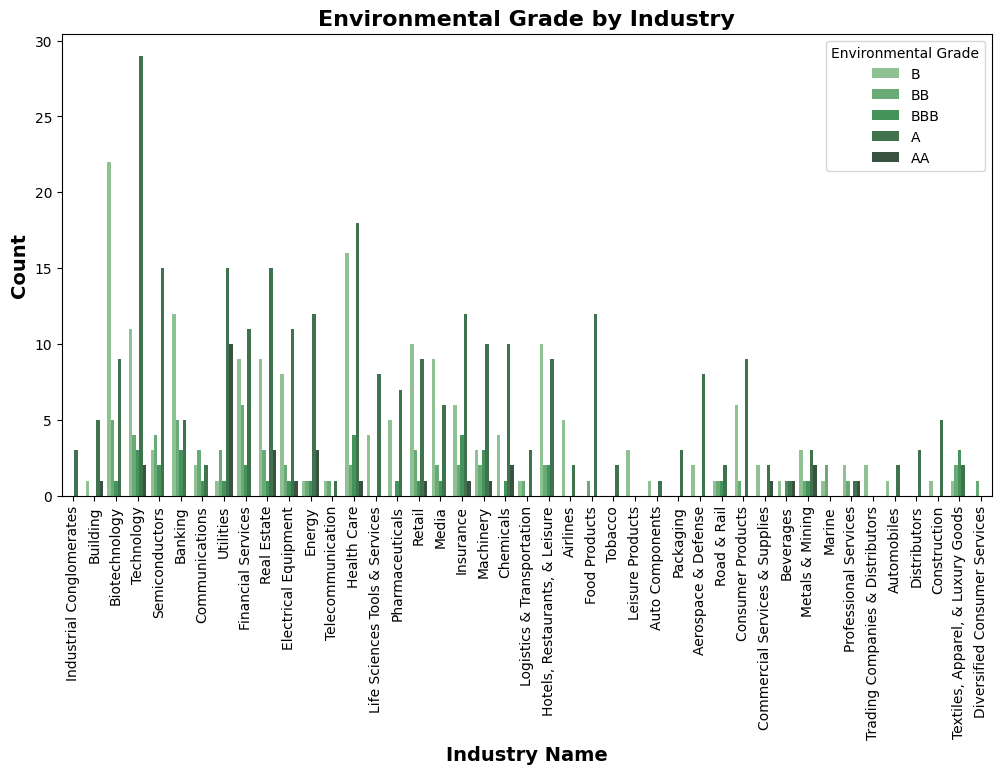

In [ ]:
# Bar plot for Environmental Grade
plt.figure(figsize = (12, 6))
sns.countplot(data = merged_df, x = 'industry', hue = 'environment_grade', palette = 'Greens_d', hue_order = ['B','BB', 'BBB', 'A','AA'])
plt.title('Environmental Grade by Industry', fontsize = 16, fontweight = 'bold', horizontalalignment = 'center')
plt.xticks(rotation = 90)
plt.xlabel('Industry Name', fontsize = 14, fontweight = 'bold')
plt.ylabel('Count', fontsize = 14, fontweight = 'bold')
plt.legend(title = 'Environmental Grade')
plt.show()

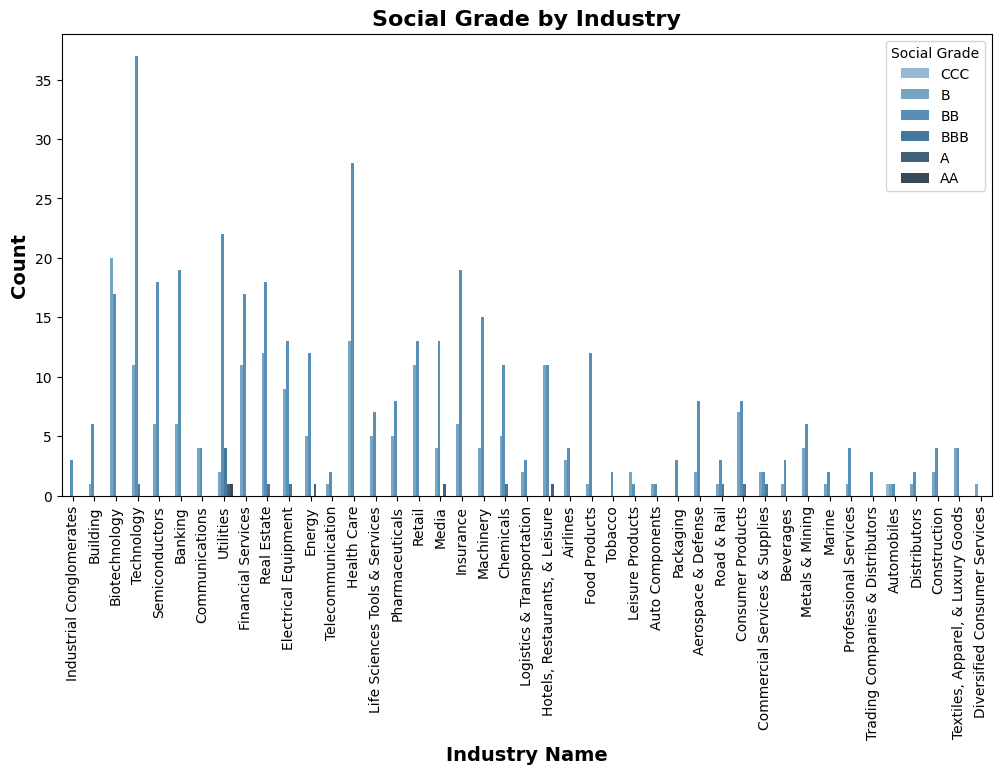

In [ ]:
# Bar plot for Social Grade
plt.figure(figsize = (12, 6))
sns.countplot(data = merged_df, x = 'industry', hue = 'social_grade', palette = 'Blues_d', hue_order = ['CCC','B','BB', 'BBB', 'A','AA'])
plt.title('Social Grade by Industry', fontsize = 16, fontweight = 'bold', horizontalalignment = 'center')
plt.xticks(rotation = 90)
plt.xlabel('Industry Name', fontsize = 14, fontweight = 'bold')
plt.ylabel('Count', fontsize = 14, fontweight = 'bold')
plt.legend(title = 'Social Grade')
plt.show()

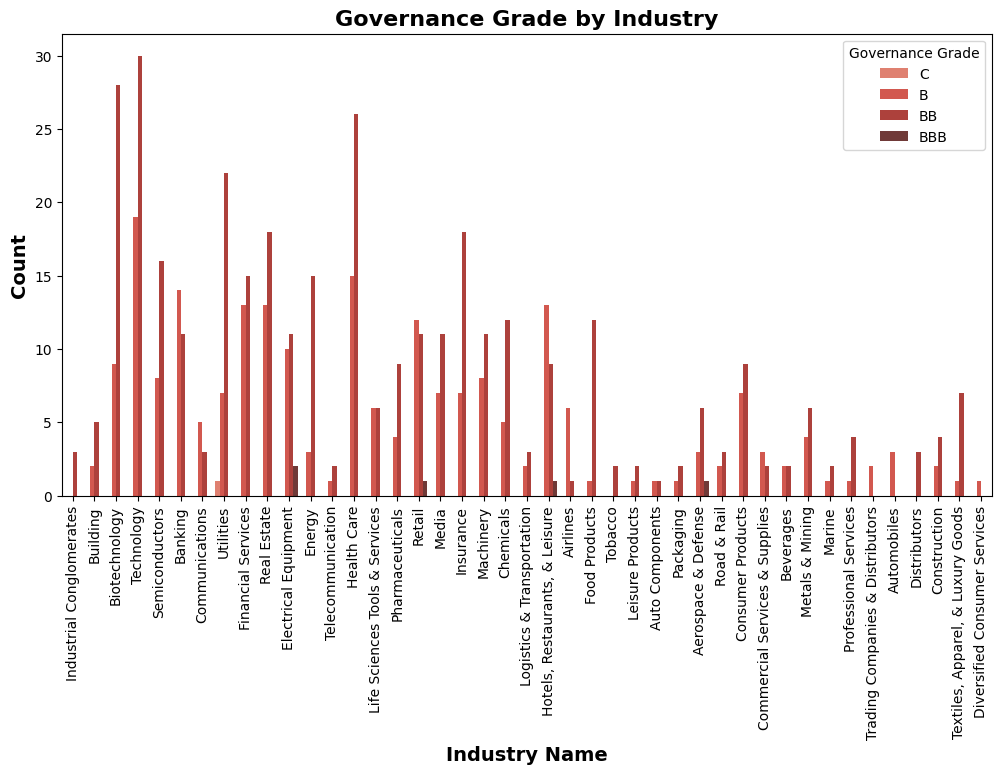

In [94]:
# Bar plot for Governance Grade
plt.figure(figsize = (12, 6))
sns.countplot(data = merged_df, x = 'industry', hue = 'governance_grade', palette = 'Reds_d', hue_order = ['C','B','BB', 'BBB'])
plt.title('Governance Grade by Industry', fontsize = 16, fontweight = 'bold', horizontalalignment = 'center')
plt.xticks(rotation = 90)
plt.xlabel('Industry Name', fontsize = 14, fontweight = 'bold')
plt.ylabel('Count', fontsize = 14, fontweight = 'bold')
plt.legend(title='Governance Grade')
plt.show()

The bar plots showing ESG grades follow a similar pattern to those with ESG levels but provide more detailed ratings. We are keeping these plots for potential use in future research, in case the ESG grades become relevant for further analysis. 

---
### part three - linear regression amongst ESG and stock percentage change

In [95]:
X = merged_df[['environment_score', 'social_score','governance_score']]   
y = merged_df['percentage_change']  

model = LinearRegression().fit(X, y)
print(f"environmental score coefficient: {model.coef_[0]}")
print(f"social score coefficient: {model.coef_[1]}")
print(f"governance score coefficient: {model.coef_[2]}")
print(f"intercept: {model.intercept_}")

environmental score coefficient: 0.12665873661386057
social score coefficient: -0.005993658756645202
governance score coefficient: -0.1639549176795246
intercept: -4.366110595319325


For every 1-unit increase in the Environmental score (assuming all other variables remain constant), the stock percentage change is expected to increase by 0.1079 units. The positive coefficient suggests that higher Environmental scores are associated with better stock performance (or higher returns).

For every 1-unit increase in the Social score (assuming all other variables remain constant), the stock percentage change is expected to decrease by 0.0237 units. The negative coefficient indicates that better Social scores might be associated with lower stock performance, but generally, since the coefficient is so close to 0, Social scores seem to have little impact on stock performance.

For every 1-unit increase in the Governance score (assuming all other variables remain constant), the stock percentage change is expected to decrease by 0.0750 units. This negative coefficient suggests that improvements in governance (e.g., stricter regulation or more ethical practices) are associated with slightly lower stock returns. This could imply that governance improvements come at a financial cost.

---
### part four - distribution of ESG and financial metrics

#### ESG vs financial metric wrt Industry

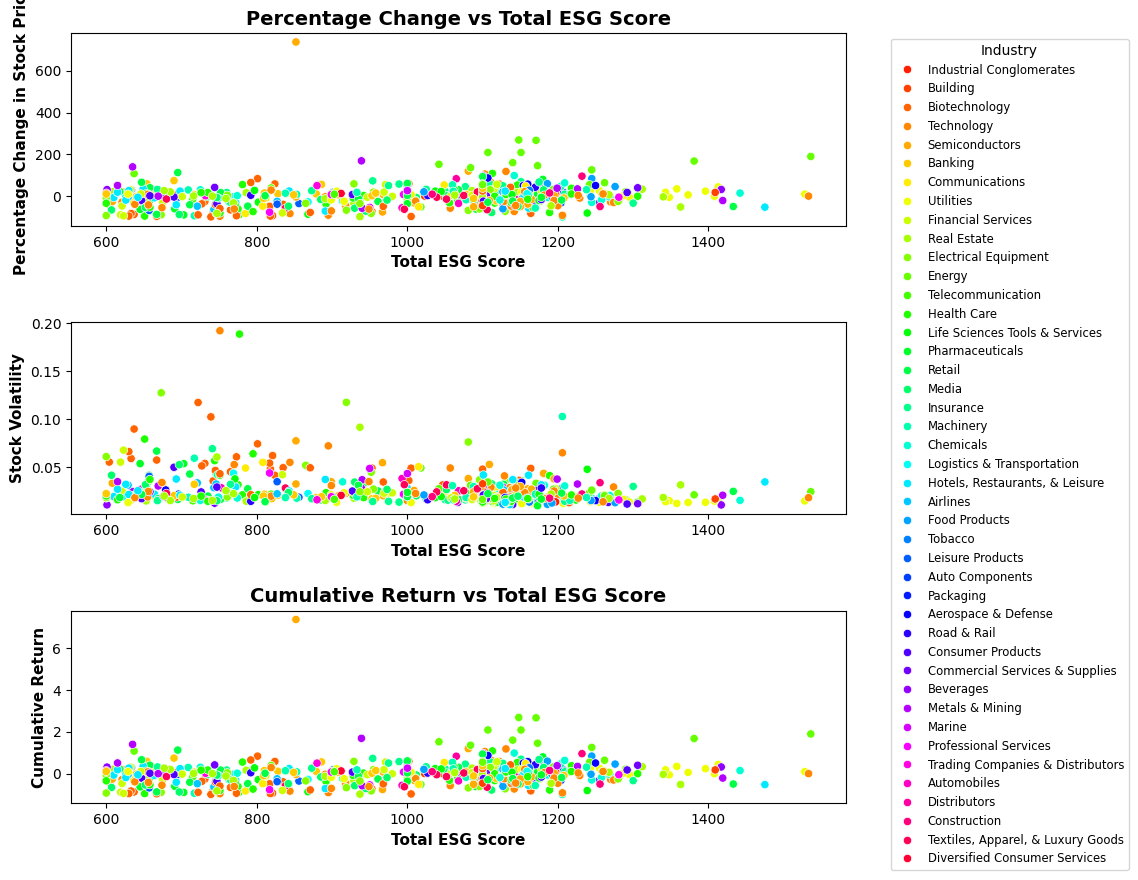

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(3, 1, figsize = (10, 10))
palette = sns.color_palette('tab20', n_colors = merged_df['industry'].nunique())
distinct_colors = sns.color_palette("hsv", n_colors=43)

# Scatter plot: Percentage Change vs. Total ESG Score (with legend)
sns.scatterplot(data = merged_df, x = 'total_score', y = 'percentage_change', hue = 'industry', palette = distinct_colors, ax = axes[0])
axes[0].set_title("Percentage Change vs Total ESG Score", fontsize = 14, horizontalalignment = 'center', fontweight = 'bold')
axes[0].set_xlabel("Total ESG Score", fontsize = 11, fontweight = 'bold', horizontalalignment = 'center')
axes[0].set_ylabel("Percentage Change in Stock Price", fontsize = 11, fontweight = 'bold', horizontalalignment = 'center')
axes[0].legend(title='Industry',bbox_to_anchor = (1.05, 1), loc = 'upper left', fontsize = 'small')

# Scatter plot: Volatility vs. Total ESG Score (no legend)
sns.scatterplot(data = merged_df, x = 'total_score', y = 'volatility', hue = 'industry', palette = distinct_colors, ax = axes[1], legend = False)
axes[1].set_xlabel("Total ESG Score", fontsize = 11, fontweight = 'bold', horizontalalignment = 'center')
axes[1].set_ylabel("Stock Volatility", fontsize = 11, fontweight = 'bold', horizontalalignment = 'center')

# Scatter plot: Cumulative Return vs. Total ESG Score (no legend)
sns.scatterplot(data = merged_df, x = 'total_score', y = 'cumulative_return', hue = 'industry', palette = distinct_colors, ax = axes[2], legend = False)
axes[2].set_title("Cumulative Return vs Total ESG Score", fontsize = 14, horizontalalignment = 'center', fontweight = 'bold')
axes[2].set_xlabel("Total ESG Score", fontsize = 11, fontweight = 'bold', horizontalalignment = 'center')
axes[2].set_ylabel("Cumulative Return", fontsize = 11, fontweight = 'bold', horizontalalignment = 'center')

plt.subplots_adjust(hspace = 0.5)
plt.show()
plt.clf()


1. Percentage Change vs Total ESG Score: The first plot displays the relationship between Total ESG Score and percentage change in stock price. The data points are widely scattered, indicating no clear correlation between ESG scores and drastic stock price changes across industries. However, companies with higher ESG scores tend to have less extreme changes in stock prices, suggesting stability.   
   
2. Volatility vs Total ESG Score: The second plot displays the stock volatility as a function of Total ESG Score. Overall, companies with higher ESG scores appear to have lower volatility, reflecting that higher ESG performance might be associated with less risky, more stable stock behavior.   
   
3. Cumulative Return vs Total ESG Score: The third plot displays  the cumulative return relative to Total ESG Score. This plot is very similar to the first plot with Percentage Change vs Total ESG Score, suggesting Cumulative Return can be removed as a potential influential variable.   

#### total ESG score vs financial metric with unnamed industry

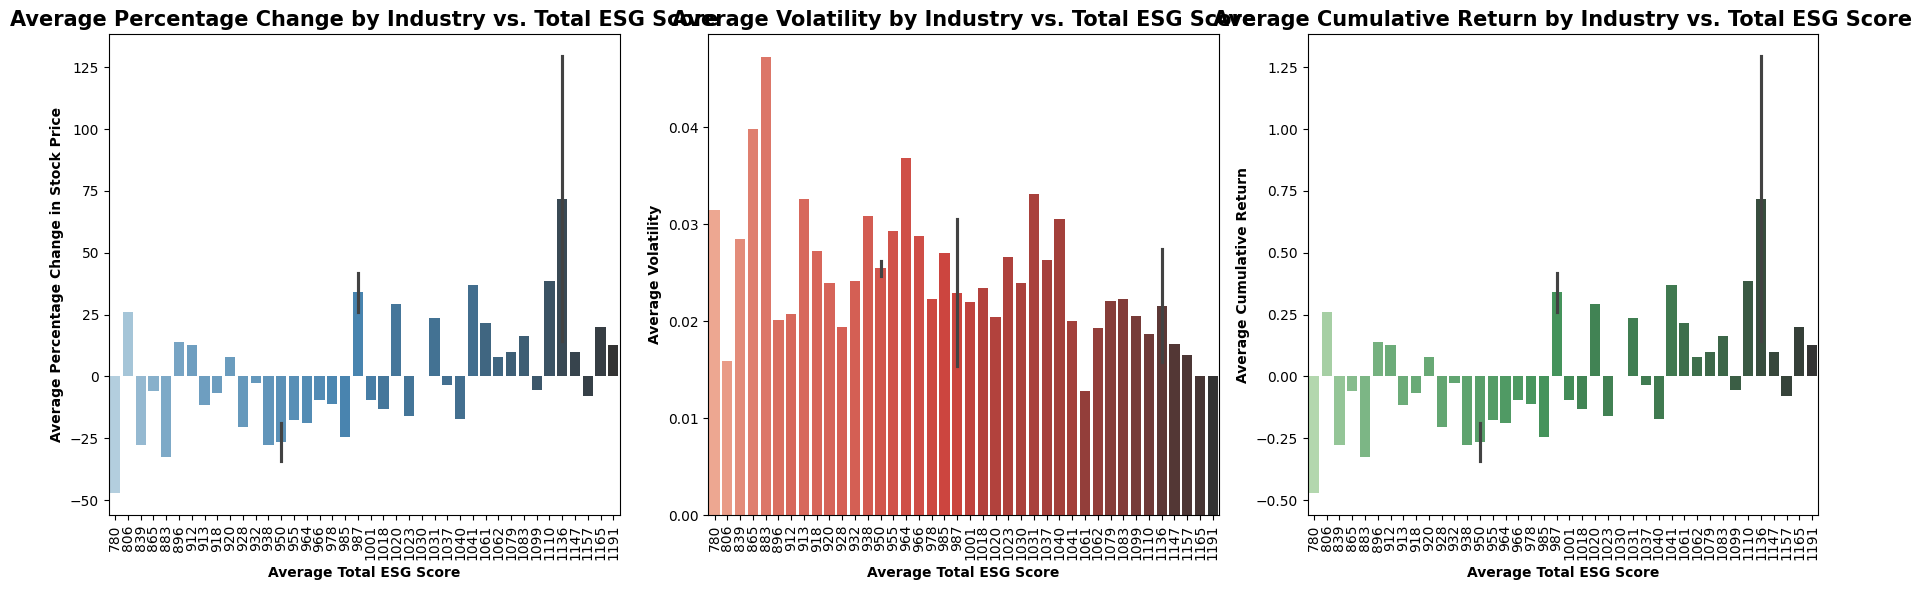

In [97]:
industry_avg = merged_df.groupby('industry').agg({
    'environment_score': 'mean',
    'social_score': 'mean',
    'governance_score': 'mean',
    'total_score': lambda x: round(x.mean()),  
    'percentage_change': 'mean',
    'volatility': 'mean',
    'cumulative_return': 'mean'}).reset_index()

fig, axes = plt.subplots(1, 3, figsize = (18, 6)) 

# Average Percentage Change by Industry vs. Total ESG Score
sns.barplot(data = industry_avg, x = 'total_score', y = 'percentage_change', hue = 'total_score', palette = 'Blues_d', ax = axes[0], legend = False)
axes[0].set_title("Average Percentage Change by Industry vs. Total ESG Score", fontweight = 'bold', horizontalalignment = 'center', size = 15)
axes[0].set_xlabel("Average Total ESG Score",  fontweight = 'bold', horizontalalignment = 'center')
axes[0].set_ylabel("Average Percentage Change in Stock Price",  fontweight = 'bold', horizontalalignment = 'center')
axes[0].tick_params(axis = 'x', rotation = 90)

# Average Volatility by Industry vs. Total ESG Score
sns.barplot(data = industry_avg, x = 'total_score', y = 'volatility', hue = 'total_score', palette = 'Reds_d', ax = axes[1], legend = False)
axes[1].set_title("Average Volatility by Industry vs. Total ESG Score", fontweight = 'bold', horizontalalignment = 'center', size = 15)
axes[1].set_xlabel("Average Total ESG Score", fontweight = 'bold', horizontalalignment = 'center')
axes[1].set_ylabel("Average Volatility",  fontweight = 'bold', horizontalalignment = 'center')
axes[1].tick_params(axis = 'x', rotation = 90)

# Average Cumulative Return by Industry vs. Total ESG Score
sns.barplot(data = industry_avg, x = 'total_score', y = 'cumulative_return', hue = 'total_score', palette = 'Greens_d', ax = axes[2], legend = False)
axes[2].set_title("Average Cumulative Return by Industry vs. Total ESG Score", fontweight = 'bold', horizontalalignment = 'center', size = 15)
axes[2].set_xlabel("Average Total ESG Score", fontweight = 'bold', horizontalalignment = 'center')
axes[2].set_ylabel("Average Cumulative Return", fontweight = 'bold', horizontalalignment = 'center')
axes[2].tick_params(axis = 'x', rotation = 90)

plt.tight_layout()
plt.show()

1. Average Percentage Change by Industry vs. Total ESG Score: This plot shows the average percentage change in stock price for each industry relative to its average Total ESG Score. Based on the plot, industries with lower ESG scores tend to exhibit more negative price changes, while those with higher ESG scores generally show more positive price changes.   
   
2. Average Volatility by Industry vs. Total ESG Score: The second plot shows the average stock volatility for each industry compared to its Total ESG Score. The plot illustrates a decreasing pattern, in which when industries have lower ESG scores usually exhibit greater volatility, suggesting that companies with lower ESG performance may experience more unpredictable stock behavior. In contrast, higher ESG scores are associated with relatively lower volatility.   
   
3. Average Cumulative Return by Industry vs. Total ESG Score: This plot shows the relationship between cumulative stock returns and Total ESG Score by industry. Trends illustrated in this plot is similar to the first plot, again, indicating Cumulative Return might not be a significant variable if we already included Percentage Change in our model.   

--- 
### part five - summary statistics and correlation analysis

       environment_score  social_score  governance_score  total_score  \
count         594.000000    594.000000        594.000000   594.000000   
mean          420.230640    297.308081        280.003367   997.542088   
std           141.833878     56.327946         47.740021   215.414802   
min           200.000000    160.000000         75.000000   600.000000   
25%           262.500000    260.000000        235.000000   801.250000   
50%           500.000000    303.000000        300.000000  1079.500000   
75%           525.000000    324.750000        310.000000  1152.750000   
max           719.000000    667.000000        475.000000  1536.000000   

       percentage_change  volatility  cumulative_return  
count         594.000000  594.000000         594.000000  
mean            1.169879    0.026527           0.011699  
std            58.452804    0.017976           0.584528  
min           -99.695055    0.009960          -0.996951  
25%           -29.612999    0.017018          -0.296

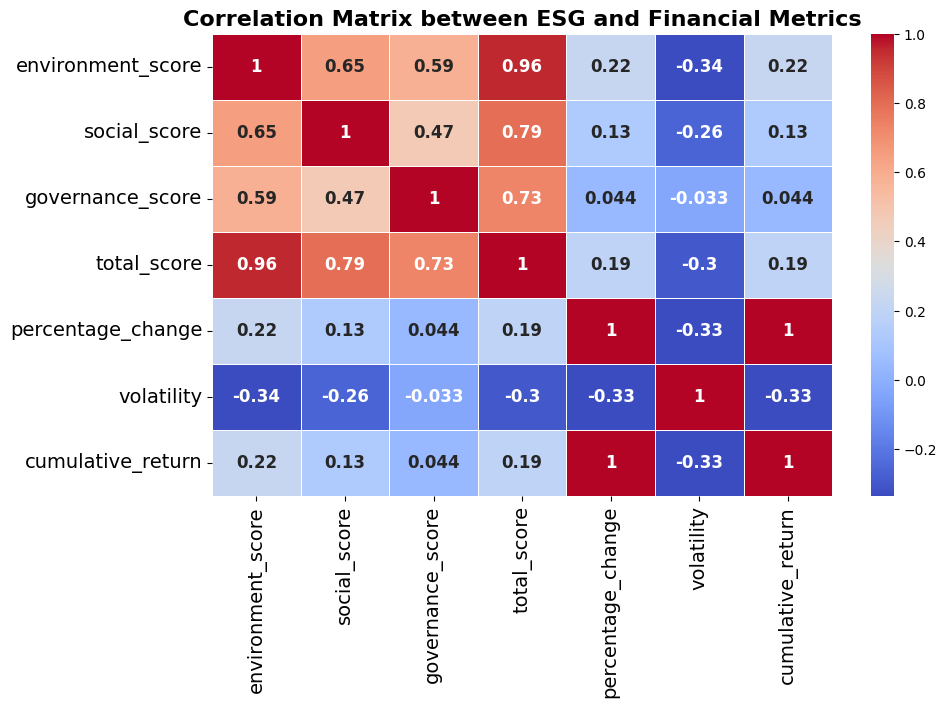

In [98]:
# Summary statistics
summary_stats = merged_df[['environment_score', 'social_score', 'governance_score', 'total_score', 
                           'percentage_change', 'volatility', 'cumulative_return']].describe()
print(summary_stats)

# Correlation matrix
correlation_matrix = merged_df[['environment_score', 'social_score', 'governance_score', 'total_score', 
                                'percentage_change', 'volatility', 'cumulative_return']].corr()

plt.figure(figsize = (10, 6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', linewidths = 0.5, annot_kws = {"size": 12, "fontweight": 'bold'})
plt.title('Correlation Matrix between ESG and Financial Metrics', fontsize = 16, fontweight = 'bold', horizontalalignment = 'center')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

The color intensity represents the strength of the correlation, with red indicating positive correlation and blue indicating negative correlation.    
    
Based on the Correlation matrix, strong positive correlation is illustrated between the E/S/G and total ESG scores, indictaed by intermediate red color. However, the correlation appear to be relatively weak between ESG scores and stock performance measurements:    

Percentage Change: ESG scores have weak positive correlations with stock price percentage changes, with environmental and total scores showing the strongest relationships (0.23 and 0.20, respectively).   
Volatility: All ESG scores are negatively correlated with volatility. The environmental score (-0.34) and total ESG score (-0.30) show the strongest negative correlations, suggesting that higher ESG performance is associated with lower stock price volatility.   
Cumulative Return: ESG scores have weak positive correlations with cumulative return, with environmental and total scores showing the most significant relationships (0.23 and 0.20), implying that higher ESG scores may be linked to better long-term returns.   


--- 
### part six - linear and logistic regression with predictions

Linear Regression: 
Root Mean Squared Error: 53.68368904815615
R-squared: 0.08470540453146558


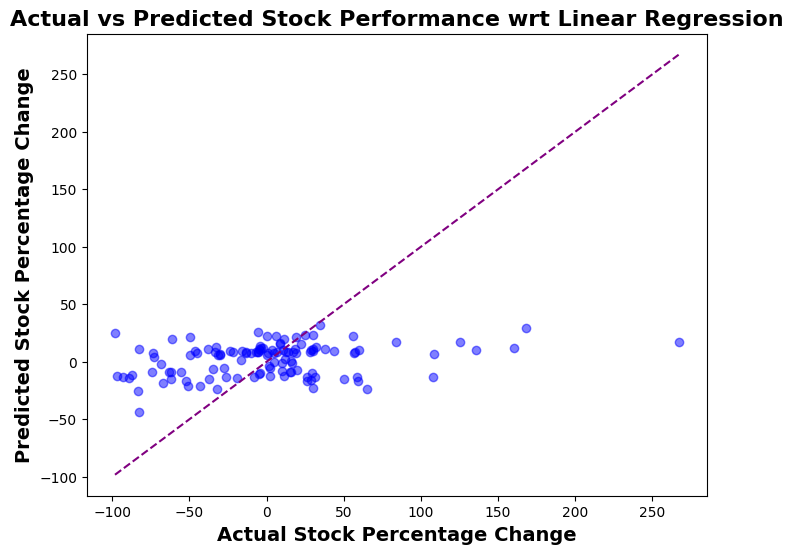

Logistic Regression Model Accuracy: 0.5714285714285714
                            OLS Regression Results                            
Dep. Variable:         stock_increase   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     11.54
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           2.61e-07
Time:                        13:22:39   Log-Likelihood:                -327.67
No. Observations:                 475   AIC:                             663.3
Df Residuals:                     471   BIC:                             680.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [99]:
# Linear Regression - Predicting Stock Performance (percentage_change) based on ESG Scores
X = merged_df[['environment_score', 'social_score', 'governance_score', 'total_score']]
y = merged_df['percentage_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression: \nRoot Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

plt.figure(figsize = (8, 6))
plt.scatter(y_test, y_pred, color = 'blue', alpha = 0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'purple', linestyle = '--')
plt.title('Actual vs Predicted Stock Performance wrt Linear Regression', size = 16, fontweight = 'bold', ha = 'center')
plt.xlabel('Actual Stock Percentage Change', size = 14, fontweight = 'bold', ha = 'center')
plt.ylabel('Predicted Stock Percentage Change', size = 14, fontweight = 'bold', ha = 'center')
plt.show()

# Logistic Regression - Binary Stock Increase/Decrease
merged_df['stock_increase'] = np.where(merged_df['percentage_change'] > 0, 1, 0)
X = merged_df[['environment_score', 'social_score', 'governance_score', 'total_score']]
y = merged_df['stock_increase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Model Accuracy: {accuracy}")
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const)
results = model.fit()
print(results.summary())

We are building two models to predict stock performance based on ESG (Environmental, Social, and Governance) scores:   
   
Linear Regression: With a low R-squared value of 0.06 and a relatively high RMSE of 50.03, the model shows that ESG scores have limited predictive power for percentage change in stock prices. The model struggles to explain the majority of stock price variability.   
    
Logistic Regression: The model's accuracy of 58% and precision/recall metrics show that ESG scores alone do not effectively predict whether a stock will increase or decrease in value.   

The perfornace of both Linear Regression and Logistic Regression indicates we might need to explore other regression methods in interepreting companies' ESG measurements and their stock performances. 

--- 
### part seven - time series analysis of sample company stock percentage changes

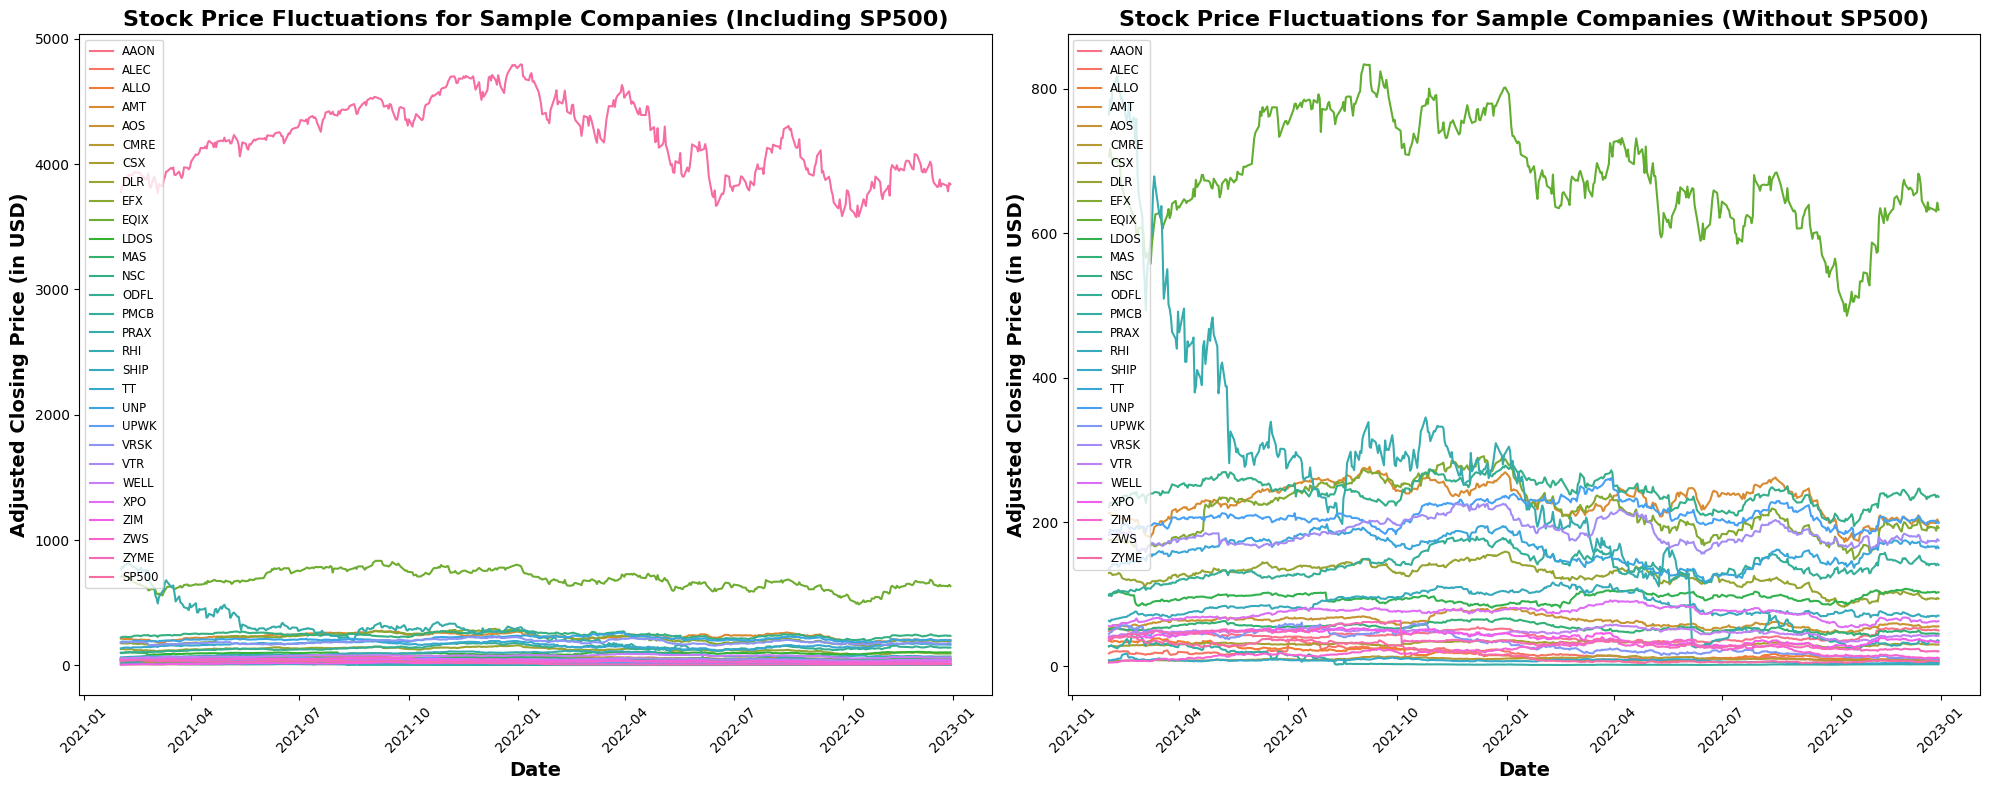

In [100]:
data_with_sp500 = yf.download(list(sample_companies['ticker']) + ['^GSPC'], start = '2021-02-01', end = '2022-12-31', progress = False)['Adj Close']
data_with_sp500.rename(columns = {'^GSPC': 'SP500'}, inplace = True)
data_without_sp500 = yf.download(list(sample_companies['ticker']), start = '2021-02-01', end = '2022-12-31', progress = False)['Adj Close']
fig, axes = plt.subplots(1, 2, figsize = (20, 8))  

# Plot WITH S&P 500
colors_with_sp500 = sns.color_palette('husl', len(data_with_sp500.columns))
for i, ticker in enumerate(data_with_sp500.columns):
    axes[0].plot(data_with_sp500.index, data_with_sp500[ticker], label = ticker, color = colors_with_sp500[i])
axes[0].set_xlabel('Date', fontweight = 'bold', ha = 'center', size = 14)
axes[0].set_ylabel('Adjusted Closing Price (in USD)', fontweight = 'bold', ha = 'center', size = 14)
axes[0].set_title('Stock Price Fluctuations for Sample Companies (Including SP500)', fontweight = 'bold', ha = 'center', size = 16)
axes[0].legend(loc = 'upper left', fontsize = 'small')
axes[0].tick_params(axis = 'x', rotation = 45)

# Plot WITHOUT S&P 500
colors_without_sp500 = sns.color_palette('husl', len(data_without_sp500.columns))
for i, ticker in enumerate(data_without_sp500.columns):
    axes[1].plot(data_without_sp500.index, data_without_sp500[ticker], label = ticker, color = colors_without_sp500[i])
axes[1].set_xlabel('Date', fontweight = 'bold', ha = 'center', size = 14)
axes[1].set_ylabel('Adjusted Closing Price (in USD)', fontweight = 'bold', ha = 'center', size = 14)
axes[1].set_title('Stock Price Fluctuations for Sample Companies (Without SP500)', fontweight = 'bold', ha = 'center', size = 16)
axes[1].legend(loc = 'upper left', fontsize = 'small')
axes[1].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()

These side-by-side line plots illustrate the stock price changes over time for selected companies, both with and without the inclusion of the S&P 500 index (^GSPC), from February 2021 to December 2022.   
    
Left Plot (Including S&P 500): This plot shows the adjusted closing prices for the selected companies alongside the S&P 500 index. The S&P 500 (pink line) dominates the chart due to its much higher adjusted closing price compared to individual companies. This makes the comparison between the companies harder to interpret visually because the large scale of the S&P 500 price compresses the other stock prices.   
    
Right Plot (Without S&P 500): This plot excludes the S&P 500, making the individual stock prices of the selected companies easier to differentiate. With the S&P 500 removed, we can observe the individual trends more clearly, including which companies experienced significant growth or fluctuations during the observed period. Notable trends include some companies showing relatively stable prices, while others display more pronounced volatility.


---
### __Questions for Reviewers:__

1. Does it seem like we have enough columns in merged_df and sample_companies to satisfy the complexity requirement for the project? Does our research question also seem complex enough given our EDA?
   
2. Is there any advice or recommended steps to follow in creating our sample_companies dataset from the population? If not, is our method of sampling acceptable? We wanted to get some feedback before proceeding with a lot of analyses for sample_companies, so the bulk of our EDA involves merged_df (as a refresher - we have one big dataset, merged_df with 600 companies that we did some EDA with, but we also want to include a smaller sample dataset so we can look at some individual companies as well. the purpose of this smaller dataset would be then to observe trends on a company-level, and study the metrics of our research question on this smaller scale). Is our sample size of 30 also acceptable?
   
3. How many visualizations (or like data analysis chunks) are recommended for the final project? (ballpark range would be helpful, or if there's any better way of quantifying, or will we get to look at some examples of a completed project later?)

4. Do the visualizations we currently have seem like they're on the right path for the final phases? Is there anything glaringly obvious that should be changed or labeled better?
 
5. Regarding the visualizations and stuff we have made for our EDA so far: should we further explore these specific visualizations more in depth? Or should we expand our DA to other variables in the datasets that we maybe haven't used yet?

6. We were looking at the guidelines for phase III as well - are you able to give us an example of a 'sample analysis' that we should aim to present in that part, based on the EDA that we currently have done? We are little confused about what that entails. 